In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

import time
from functools import wraps
from xml.etree import ElementTree

import pandas as pd
import numpy as np
from datetime import datetime, date
from pykrx import stock



In [2]:
# def my_ticker(*names):    
#     df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
#     df_code.종목코드 = df_code['종목코드'].map('{:06d}'.format)   # 종목코드를 6자리 숫자 포맷으로 바꿔라(dict)
#     df_code = df_code[['회사명', '종목코드']]
#     code_list = []
#     for name in names:
#         code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
#         code_list.append(code)
#     return code_list
# #     return code.strip()
# my_ticker('삼성전자','현대자동차')

In [3]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)
    # print(f"df_code : {df_code}")
    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code_list.append(code)
    return code_list

# stocks = my_ticker(['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER'])
# print(stocks)

In [4]:
# def logger(func):  # func : my_krx
#     @wraps(func)   # my_krx의 파라미터를 전달받은 것처럼 사용가능
#     def wrapper(*args, **kwargs):
#         start = time.perf_counter()
#         success, failed = func(*args, **kwargs)
#         end = time.perf_counter() - start
#         func_start, func_end = args[0], args[1]
#         print(#f'#date: {func_start} ~ {func_end}, \n',
#               f'#success: {success} item(s), \n',
#               f'#failed: {failed} item(s), \n',
#              )
#     return wrapper
# @logger  # preprocessing : 다른 업무를 수행하다가 해당 함수가 호출되면 상단에 있는 코드를 실행
def my_krx(start, end, *codes):
    error_list = []
    failed = 0
    success = 0
    for code in codes:
        try:
            df = stock.get_market_ohlcv_by_date(start, end, code)
            df.reset_index(inplace=True)
            df.insert(loc=1, column='종목코드', value=code)
            df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
            success += 1
        except ElementTree.ParseError as e:   # 크롤링 관련된 에러발생 시
            error_list.append(e)
            drop_rows(database, table, code)  # 특정 종목코드에서 에러 발생 시 해당 종목코드에 대한 데이터 삭제 후 다음 종목코드로 넘어감
            failed += 1
            continue
        except Exception as e:                # 그 외 에려
            print('Error occurred : ', e)
            failed += 1
            continue
    print(f'success:{success}, failed:{failed}')
    return df

In [5]:
stocks = ['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER']
stock_code = my_ticker(stocks)
print(stock_code)

df = pd.DataFrame()
for i, code in enumerate(stock_code):
    col = stocks[i]
    df[col]= my_krx('20160104', '20180427', code)['종가']
df.head()

['005930', '000660', '005380', '035420']
Error occurred :  Length mismatch: Expected axis has 9 elements, new values have 7 elements
success:0, failed:1
Error occurred :  Length mismatch: Expected axis has 9 elements, new values have 7 elements
success:0, failed:1
Error occurred :  Length mismatch: Expected axis has 9 elements, new values have 7 elements
success:0, failed:1
Error occurred :  Length mismatch: Expected axis has 9 elements, new values have 7 elements
success:0, failed:1


,삼성전자,SK하이닉스,현대자동차,NAVER
0,1205000,30150,144000,632000
1,1208000,30600,143500,637000
2,1175000,30750,140000,623000
3,1163000,30200,137500,652000
4,1171000,29700,136500,652000


# Data Load

In [6]:
df = pd.read_csv("./datasets/kospi_top10.csv")  
df = df.set_index("날짜")
df = df.iloc[:, [0,1,9]]
df

,삼성전자,LG에너지솔루션,기아
날짜,,,
2023-04-03,63100,586000,81200
2023-04-04,63600,575000,80100
2023-04-05,63900,588000,81300
2023-04-06,62300,580000,81000
2023-04-07,65000,580000,80100
2023-04-10,65700,596000,81000
2023-04-11,65900,610000,85000
2023-04-12,66000,590000,86100
2023-04-13,66100,599000,86600


In [7]:
daily_ret = df.pct_change()         # 일간 수익률
annual_ret = daily_ret.mean() * 252 # 연간 수익률
daily_cov = daily_ret.cov()         # 일별 공분산행렬
annual_cov = daily_cov * 252        # 연간 공분산행렬

In [8]:
port_ret = [] 
port_risk = [] 
port_weights = [] 

stocks = df.columns   # 삼성전자,LG에너지솔루션,기아

for _ in range(20000): 
    weights = np.random.random(len(stocks))   # 몬테카를로 : 나올 수 있는 모든 가중치 경우의 수를 다룸 --> 한번에 3개의 가중치
    weights /= np.sum(weights)                # 가중치의 합이 1이어야 함 -> 가중치의 확률 사용 = 가중치/가중치3개의 합
    returns = np.dot(weights, annual_ret)     # 기대 수익률
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # 리스크(편차)

    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 
    
portfolio = {'Returns': port_ret, 'Risk': port_risk} 
for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights]  # portfolio[s] : s를 키값으로 각각의 weight 값들이 들어감
print(portfolio.keys())

df = pd.DataFrame(portfolio) 
# df = df[['Returns', 'Risk'] + [s for s in stocks]] 
print(df.shape)
df.head()  # 삼성전자, LG에너지솔루션, 기아 각각의 w가 들어있음

dict_keys(['Returns', 'Risk', '삼성전자', 'LG에너지솔루션', '기아'])
(20000, 5)


,Returns,Risk,삼성전자,LG에너지솔루션,기아
0,0.105181,0.183869,0.316766,0.335901,0.347333
1,-0.398494,0.215587,0.417674,0.542639,0.039687
2,0.878216,0.282874,0.044814,0.072039,0.883147
3,0.009149,0.213332,0.769942,0.177261,0.052798
4,-0.142500,0.204331,0.178651,0.523250,0.298098


# 효율적 투자선
- x : risk, y : return로 하는 포트폴리오 자산 배분 전략

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


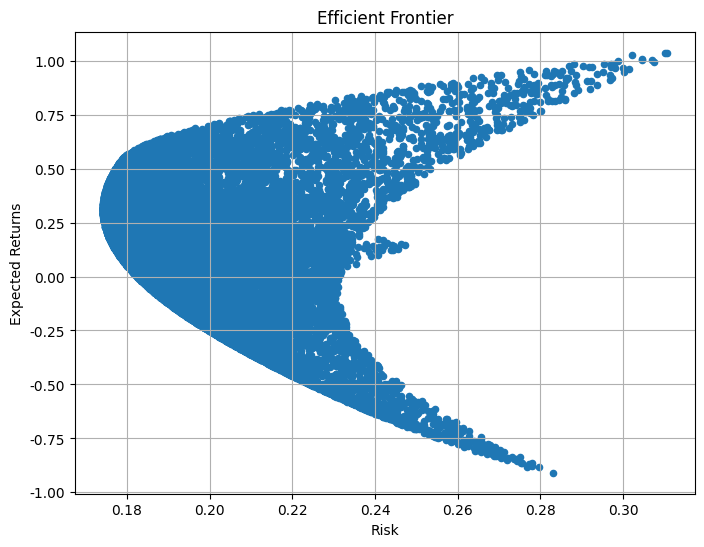

In [9]:
df.plot.scatter(x='Risk', y='Returns', figsize=(8, 6), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 